In [1]:
# IMPORTS
import os
import numpy as np
import cv2
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
import skimage.io as io

# UNet imports
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu

# Custom imports
from utilities import run

In [2]:
# Read dataset
def read_images(folder_path):
   '''
    Read images from a folder and return them as a list of numpy arrays.
    Normalize the images
   '''
   images = []
   file_names = os.listdir(folder_path)
   
   for file_name in file_names:
      # image = np.array(io.imread(os.path.join(folder_path, file_name)))/255.0
      # images.append(image)
      image = np.array(io.imread(os.path.join(folder_path, file_name)))
      images.append(image)
   
   return images
 
# read dataset 
A = read_images('dataset/trainval/A') # initial images
B = read_images('dataset/trainval/B') # images after a certain amount of time
labels = read_images('dataset/trainval/label') # ground truth images (actual change)

assert len(A) == len(B) == len(labels), "Number of images in A, B and labels are not equal."

In [3]:
# Split dataset into training, validation and test sets
A_train, A_test, B_train, B_test, labels_train, labels_test = train_test_split(A, B, labels, test_size=0.3, random_state=42)

# we can use the same function to split the training set into training and validation sets
# A_train, A_val, B_train, B_val, labels_train, labels_val = train_test_split(A_train, B_train, labels_train, test_size=0.2, random_state=42)

Random image before change


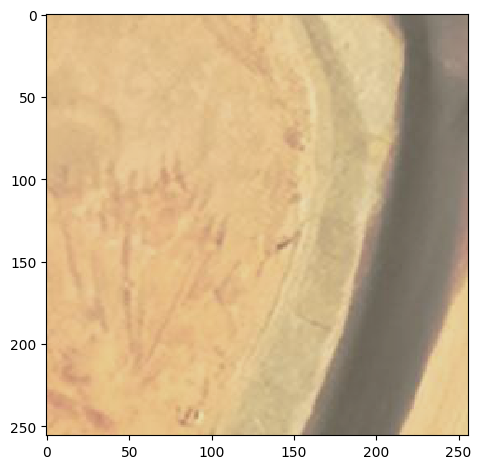

Random image after change


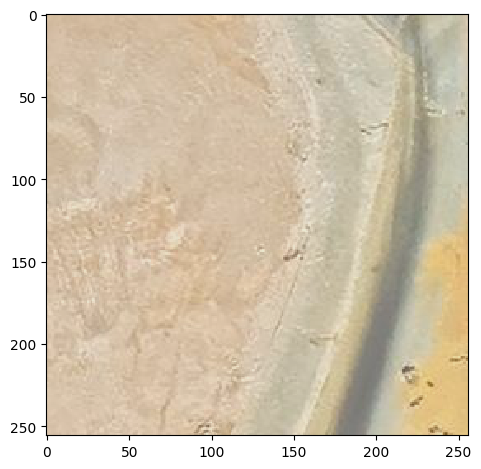

Change ground truth of the random image


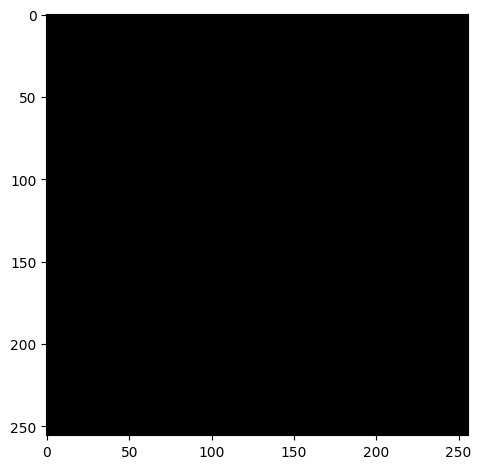

In [4]:
# Show a random image in the training set
random_index = np.random.randint(0, len(A_train))

print("Random image before change")
io.imshow(A_train[random_index])
io.show()

print("Random image after change")
io.imshow(B_train[random_index])
io.show()

print("Change ground truth of the random image")
io.imshow(labels_train[random_index])
io.show()

## ***Deep Learning Methods***

1. UNet
2. Siamese
3. SUNet

### **UNet**

UNet Architecture
1. Encoder (Contracting Path): down sampling the input image size while depth increases

    Each Block:
    - Two 3*3 Convolutional Layers zero-padded with stride=1 Each Followed by a RELU Activation
    - Max Pooling Layer 2*2 with stride=2 (Dimension halved)(Same Depth) [⬇ Down Sampling] 

2. Decoder

In [5]:
# First we build our convolution block
# A convolution block for the UNet consists of two 3x3 convolutions with ReLU activation and batch normalization
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, input):
        # first 3x3 convolution
        conv_output = self.conv(input)
        conv_output = self.bn(conv_output)
        conv_output = self.relu(conv_output)

        # second  convolution
        conv_output = self.conv(conv_output)
        conv_output = self.bn(conv_output)
        conv_output = self.relu(conv_output)

        return conv_output
    
# Next we build the encoder block
# The encoder block consists of 4 blocks with the following layers:
# 1. A convolution block
# 2. A max pooling layer
# Note: The last encoder block does not have a max pooling layer

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, input):
        conv_output = self.conv_block(input)
        pool_output = self.max_pool(conv_output)
        return conv_output, pool_output
    
# Next we build the decoder block
# The decoder block consists of 4 blocks with the following layers:
# 1. Up convolution (transposed convolution)
# 2. convoloition block
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.conv_block = ConvBlock(2*out_channels, out_channels)
    
    def forward(self, inputs, skip):
        up_conv_output = self.up_conv(inputs)
        up_conv_output = torch.cat([up_conv_output, skip], axis=1)
        up_conv_output = self.conv_block(up_conv_output)
        return up_conv_output


In [6]:
# # build the UNet model
# class UNet(nn.Module):
#     def __init__(self, n_classes):
#         super(UNet, self).__init__()
#         ''' Encoder '''
#         self.encoder_block1 = EncoderBlock(n_classes, 64)
#         self.encoder_block2 = EncoderBlock(64, 128)
#         self.encoder_block3 = EncoderBlock(128, 256)
#         self.encoder_block4 = EncoderBlock(256, 512)
        
#         ''' Bottle Neck'''
#         self.bottleneck = ConvBlock(512, 1024)
#         # No max pooling in the bottleneck => considered last layer in the encoder
        
#         ''' Decoder '''
#         self.decoder_block4 = DecoderBlock(1024, 512)
#         self.decoder_block3 = DecoderBlock(512, 256)
#         self.decoder_block2 = DecoderBlock(256, 128)
#         self.decoder_block1 = DecoderBlock(128, 64)

        
#         ''' Classifier '''
#         self.output_conv = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)
    
#     def forward(self, input):
#         # encoder
#         e1, p1 = self.encoder_block1(input)
#         e2, p2 = self.encoder_block2(p1)
#         e3, p3 = self.encoder_block3(p2)
#         e4, p4 = self.encoder_block4(p3)
        
#         # bottle neck
#         bn = self.center(p4)
        
#         # decoder
#         d4 = self.decoder_block4(bn, e4)
#         d3 = self.decoder_block3(d4, e3)
#         d2 = self.decoder_block2(d3, e2)
#         d1 = self.decoder_block1(d2, e1)
        
#         # output
#         output = self.output_conv(d1)
#         return output

class dataset

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

from skimage import io

class ChangeDetectionDataset(Dataset):
    def __init__(self, root_dir,transform1,transform2):
        self.root_dir = root_dir

        self.image_folder1 = os.path.join(root_dir, 'A/')
        self.image_folder2 = os.path.join(root_dir, 'B/')
        self.label_folder = os.path.join(root_dir, 'label/')
        self.image_filenames = os.listdir(self.image_folder1)  # Assuming both folders have the same files
        self.transform1=transform1
        self.transform2=transform2

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path1 = os.path.join(self.image_folder1, img_name)
        img_path2 = os.path.join(self.image_folder2, img_name)
        label_path = os.path.join(self.label_folder, img_name)

        image1 = io.imread(img_path1)  # Transpose dimensions
        image2 = io.imread(img_path2)
        label = io.imread(label_path)
        label = label.astype('float32')  # Convert to floating point to allow division
        label = label > 0


        label = label.astype(np.int64)
        label = torch.as_tensor(label, dtype=torch.float32)
        label = label.squeeze()
        if self.transform1 and self.transform2:
            image1 = self.transform1(image1)
            image2 = self.transform2(image2)
            # label = self.transform(label)
        return {'image1': image1, 'image2': image2, 'label': label}

transform1 = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean=mu1, std=std1)
    ])
transform2 = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean=mu2, std=std2)
    ])
# Create dataset instance
dataset = ChangeDetectionDataset(root_dir='/content/trainval/trainval',transform1=transform1,transform2=transform2)

# Split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model


In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d

class SiameseUNet(nn.Module):
    """SiameseUNet segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(SiameseUNet, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)

        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):


        """Forward method."""
        # for imput image 1
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x1))))
        x12_1 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_1, kernel_size=2, stride=2)


        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_1 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_1, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_1 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_1, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_1 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_1, kernel_size=2, stride=2)

        ####################################################
        # for input image 2
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x2))))
        x12_2 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_2, kernel_size=2, stride=2)


        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_2 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_2, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_2 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_2, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_2 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_2, kernel_size=2, stride=2)



        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43_1.size(3) - x4d.size(3), 0, x43_1.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), torch.abs(x43_1 - x43_2)), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33_1.size(3) - x3d.size(3), 0, x33_1.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), torch.abs(x33_1 - x33_2)), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22_1.size(3) - x2d.size(3), 0, x22_1.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), torch.abs(x22_1 - x22_2)), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12_1.size(3) - x1d.size(3), 0, x12_1.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), torch.abs(x12_1 - x12_2)), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)



train


In [ ]:
# Define parameters
n_epochs = 10 # Assuming N_EPOCHS is defined elsewhere
criterion = torch.nn.NLLLoss()  # Assuming this is your loss function
siameseUnet = SiameseUNet(3, 2)


siameseUnet.to(DEVICE)
# optimizer = torch.optim.Adam(siameseUnet.parameters(), weight_decay=1e-4)  # Adam optimizer with weight decay

optimizer = torch.optim.AdamW(siameseUnet.parameters(), lr=0.0005)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)  # Exponential learning rate scheduler

# Training loop
for epoch_index in tqdm(range(n_epochs)):
    siameseUnet.train()
    print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(n_epochs))

    tot_loss = 0
    for batch in train_loader:
        I1 = batch["image1"].to(DEVICE)
        I2 = batch["image2"].to(DEVICE)
        label = batch['label'].to(DEVICE)

        optimizer.zero_grad()

        softmax_output,out_mask = net(I1, I2)


        loss = criterion(softmax_output, label)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted_indecies = torch.max(softmax_output.data, 1)

        # print(predicted)
        tot_loss += loss.item()

        predicted_indecies=predicted_indecies.int().cpu().numpy()

        label_np = label.cpu().numpy()

        


test


In [ ]:

jaccard_indices_sklearn=[]

from sklearn.metrics import jaccard_score
for batch in test_loader:
        I1 = batch["image1"].to(DEVICE)
        I2 = batch["image2"].to(DEVICE)
        label = batch['label'].to(DEVICE)


        softmax_output,out_mask = net(I1, I2)



        _, predicted_indecies = torch.max(softmax_output.data, 1)

        

        predicted_indecies=predicted_indecies.int().cpu().numpy()

        label_np = label.cpu().numpy()

        for i in range(predicted_indecies.shape[0]):
          cv2.imwrite("/content/images/"+f'{i}'+".jpg", predicted_indecies[i].reshape(256 , 256, 1)*255)
          cv2.imwrite("/content/label/"+f'{i}'+".jpg", label_np[i].reshape(256 , 256, 1)*255)

       
        jaccard_indices_sklearn.append(jaccard_score(label_np.flatten(), predicted_indecies.flatten(), zero_division=1.0))


avg_jaccard_index_sklearn = np.mean(jaccard_indices_sklearn)*100

print("AVERAGE JACCARD INDEX sklearn + ",avg_jaccard_index_sklearn)


In [8]:
loss_per_epoch,bce_loss_per_epoch,dice_loss_per_epoch,jacord_index_per_epoch,loss_per_val_epoch,bce_loss_per_val_epoch,dice_loss_per_val_epoch,jacord_index_per_val_epoch = run(UNet, A, B)

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 6124732416 bytes.